# MNIST Tutorial with PyTorch

This notebook demonstrates how to build, train, and evaluate a simple CNN model for the MNIST handwritten digit classification task using PyTorch.

## 1. Setup and Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Matplotlib is building the font cache; this may take a moment.


Using device: cpu


## 2. Load and Prepare the MNIST Dataset

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Load training data
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load test data
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Dataset info
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

100.0%
100.0%
100.0%
100.0%

Train dataset size: 60000
Test dataset size: 10000


## 3. Visualize Some Examples from the Dataset

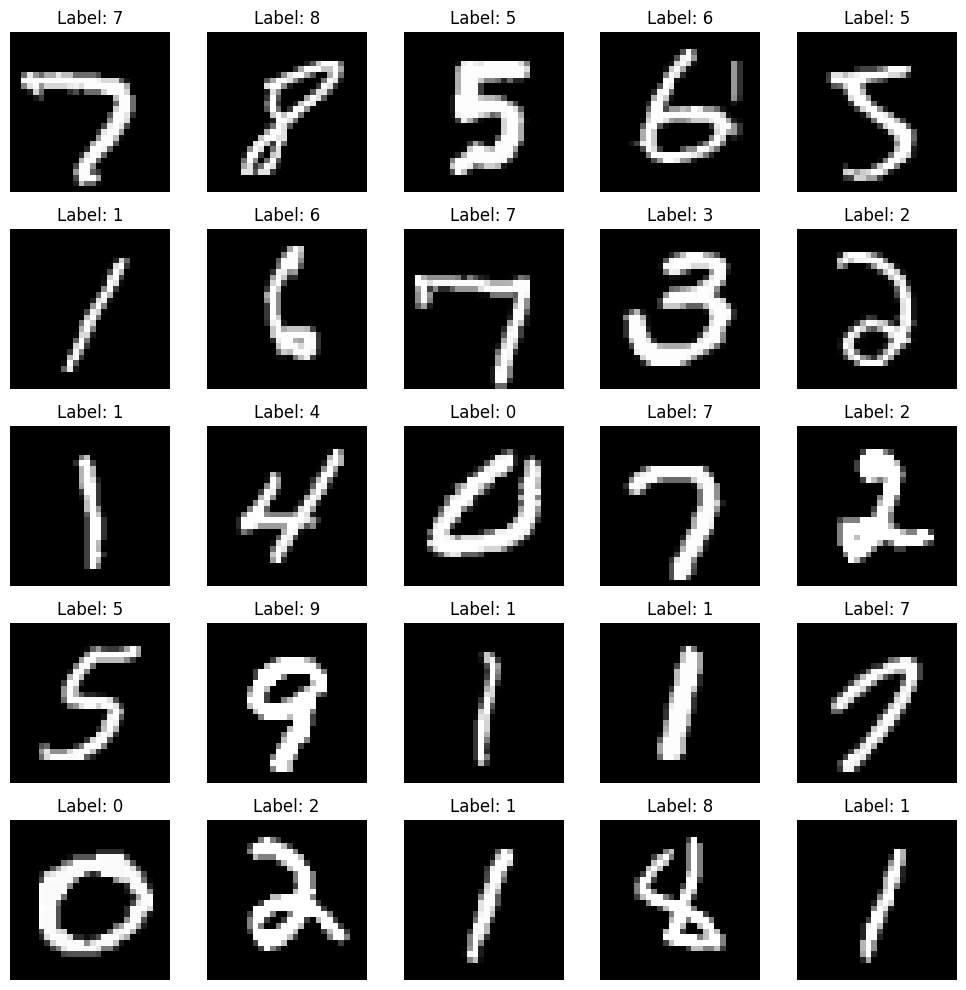

In [3]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Define the CNN Model

In [4]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        # Second conv block
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        # Flatten for fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Initialize the model
model = MnistCNN().to(device)
print(model)

MnistCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


## 5. Define Loss Function and Optimizer

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 6. Training Function

In [6]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move tensors to the configured device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # Print progress
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} | Batch: {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f} | Acc: {100.*correct/total:.2f}%')
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total
    return train_loss, train_acc

## 7. Testing Function

In [7]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            test_loss += criterion(outputs, target).item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100. * correct / total
    
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{total} ({test_acc:.2f}%)')
    return test_loss, test_acc

## 8. Train the Model

In [8]:
num_epochs = 5
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer, epoch)
    test_loss, test_acc = test(model, device, test_loader, criterion)
    
    # Store for plotting
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

print('Finished Training')

Epoch: 1 | Batch: 0/938 | Loss: 2.3051 | Acc: 14.06%
Epoch: 1 | Batch: 100/938 | Loss: 0.2715 | Acc: 81.33%
Epoch: 1 | Batch: 200/938 | Loss: 0.1859 | Acc: 87.79%
Epoch: 1 | Batch: 300/938 | Loss: 0.0676 | Acc: 90.36%
Epoch: 1 | Batch: 400/938 | Loss: 0.0901 | Acc: 92.06%
Epoch: 1 | Batch: 500/938 | Loss: 0.0494 | Acc: 93.04%
Epoch: 1 | Batch: 600/938 | Loss: 0.0292 | Acc: 93.76%
Epoch: 1 | Batch: 700/938 | Loss: 0.0248 | Acc: 94.31%
Epoch: 1 | Batch: 800/938 | Loss: 0.0415 | Acc: 94.70%
Epoch: 1 | Batch: 900/938 | Loss: 0.0649 | Acc: 95.04%
Test set: Average loss: 0.0417, Accuracy: 9865/10000 (98.65%)
Epoch 1: Train Loss: 0.1564, Train Acc: 95.13%, Test Loss: 0.0417, Test Acc: 98.65%
Epoch: 2 | Batch: 0/938 | Loss: 0.0157 | Acc: 100.00%
Epoch: 2 | Batch: 100/938 | Loss: 0.0347 | Acc: 98.11%
Epoch: 2 | Batch: 200/938 | Loss: 0.0068 | Acc: 98.30%
Epoch: 2 | Batch: 300/938 | Loss: 0.0248 | Acc: 98.31%
Epoch: 2 | Batch: 400/938 | Loss: 0.0275 | Acc: 98.39%
Epoch: 2 | Batch: 500/938 | Loss

## 9. Save the Trained Model

In [9]:
# Save model
PATH = './mnist_cnn.pth'
torch.save(model.state_dict(), PATH)
print(f'Model saved to {PATH}')

Model saved to ./mnist_cnn.pth


## 10. Visualize Training Results

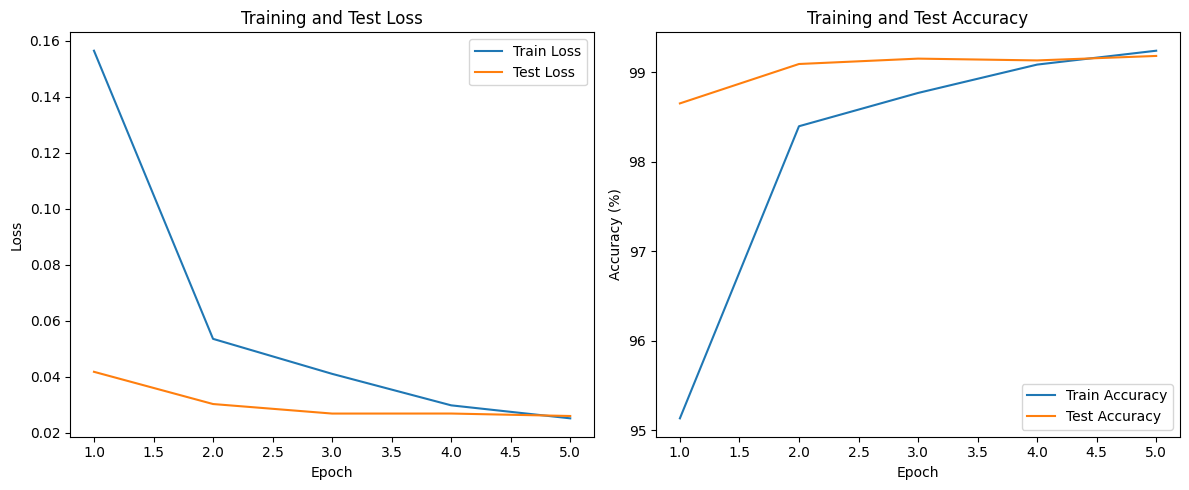

In [10]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 11. Visualize Model Predictions

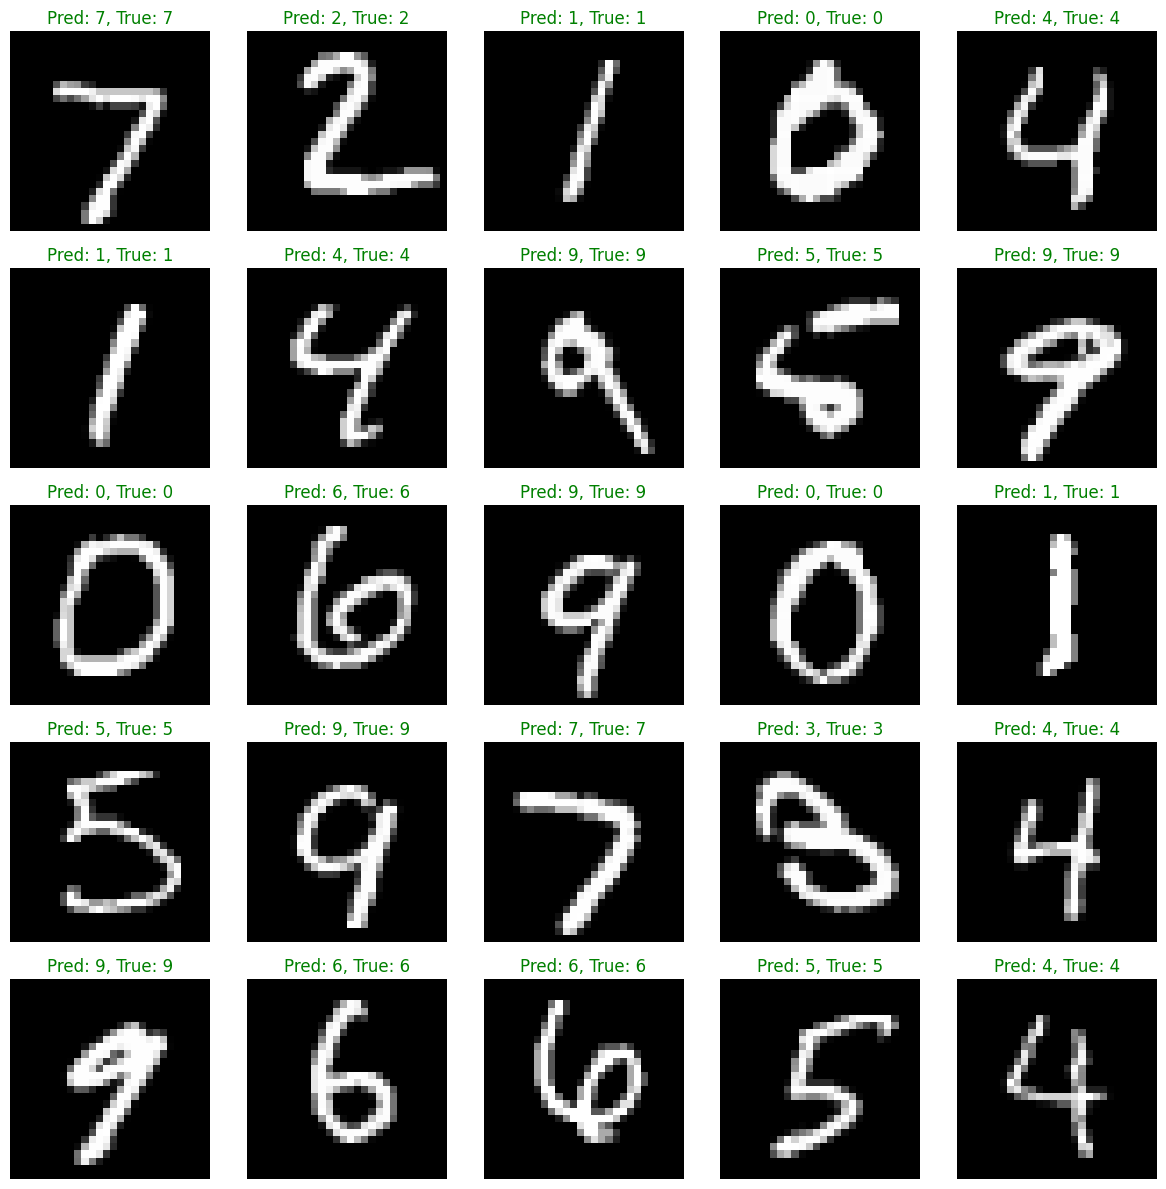

In [11]:
# Load the saved model
model_loaded = MnistCNN().to(device)
model_loaded.load_state_dict(torch.load(PATH))
model_loaded.eval()

# Get a batch of test data
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model_loaded(images.to(device))
    _, predicted = torch.max(outputs, 1)

# Plot the first 25 images with their predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].squeeze().numpy(), cmap='gray')
    col = 'green' if predicted[i] == labels[i] else 'red'
    plt.title(f'Pred: {predicted[i].item()}, True: {labels[i].item()}', color=col)
    plt.axis('off')
plt.tight_layout()
plt.show()

## 12. Generate Confusion Matrix

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get all test predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        outputs = model_loaded(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(target.numpy())

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

## 13. Visualize Feature Maps

In [ ]:
# Get a single image for visualization
single_image = images[0:1].to(device)
print(f"Image shape: {single_image.shape}")

# Define hook to get activations
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
model_loaded.conv1.register_forward_hook(get_activation('conv1'))
model_loaded.conv2.register_forward_hook(get_activation('conv2'))

# Forward pass
with torch.no_grad():
    output = model_loaded(single_image)

# Display original image
plt.figure(figsize=(6, 6))
plt.imshow(single_image.cpu().squeeze().numpy(), cmap='gray')
plt.title(f"Original Image (Label: {labels[0]})", size=16)
plt.axis('off')
plt.show()

# Display activations for conv1 (first 16 channels)
plt.figure(figsize=(16, 8))
plt.suptitle("First Convolutional Layer Activations", size=20)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(activations['conv1'][0, i].cpu().numpy(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Display activations for conv2 (first 16 channels)
plt.figure(figsize=(16, 8))
plt.suptitle("Second Convolutional Layer Activations", size=20)
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(activations['conv2'][0, i].cpu().numpy(), cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## 14. Example of Model Deployment

In [ ]:
def predict_single_image(image_tensor, model):
    """Predict the digit for a single image"""
    model.eval()
    with torch.no_grad():
        # Add batch dimension and move to device
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        
        # Get prediction and probability
        prob = F.softmax(output, dim=1)
        pred_prob, pred_label = torch.max(prob, 1)
        
    return pred_label.item(), pred_prob.item()

# Get random test image
idx = np.random.randint(0, len(test_dataset))
sample_image, sample_label = test_dataset[idx]

# Make prediction
pred_digit, confidence = predict_single_image(sample_image, model_loaded)

# Display results
plt.figure(figsize=(6, 6))
plt.imshow(sample_image.squeeze().numpy(), cmap='gray')
plt.title(f"Prediction: {pred_digit} (Confidence: {confidence:.2f})\nTrue Label: {sample_label}", size=16)
plt.axis('off')
plt.show()

## 15. Summary and Conclusion

In this tutorial, we have:

1. Loaded and visualized the MNIST dataset
2. Built a Convolutional Neural Network for digit classification
3. Trained the model and evaluated its performance
4. Visualized the training process and model predictions
5. Explored feature maps to understand what the network learns
6. Demonstrated how to use the trained model for inference

The model achieves high accuracy on the MNIST dataset, which is a common benchmark for basic image classification tasks. The visualization tools help us understand how the network processes images and makes predictions.